In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import FeatureUnion

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import dill

from flask import Flask, request, jsonify

In [4]:
from catboost import CatBoostClassifier

In [5]:
data = pd.read_csv("C:/Users/li_le/geekbrains_study/ML_business/train_case2.csv", sep=';')
data.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [7]:
data.shape

(70000, 13)

In [8]:
data['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

<AxesSubplot:>

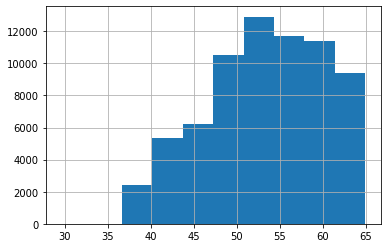

In [9]:
(data['age'] / 365).hist()

<AxesSubplot:>

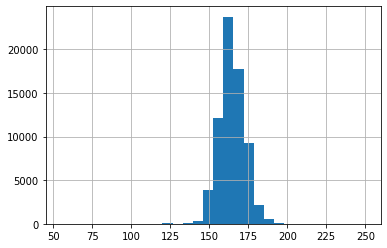

In [10]:
data['height'].hist(bins=30)

In [11]:
# судя по возрасту детей в базе нет, рост ниже 1м - явно ошибка
data.loc[(data['height'] > 230)|(data['height'] < 100), 'height'] = data['height'].median()

<AxesSubplot:>

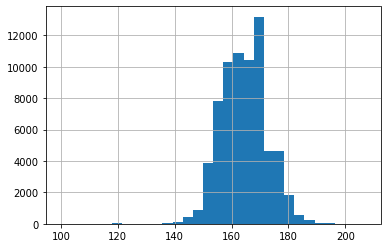

In [12]:
data['height'].hist(bins=30)

<AxesSubplot:>

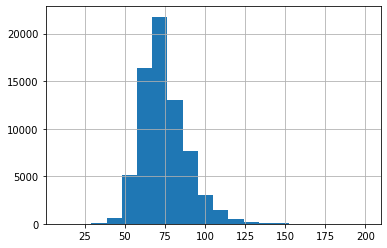

In [13]:
data['weight'].hist(bins=20)

In [14]:
data.loc[data['weight'] < 25, 'weight'] = data['weight'].median()

In [15]:
# индекс массы тела
data['BMI'] = data['weight'] / (data['height'] / 100)**2

<AxesSubplot:>

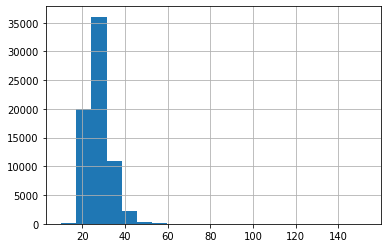

In [16]:
data['BMI'].hist(bins=20)

<AxesSubplot:>

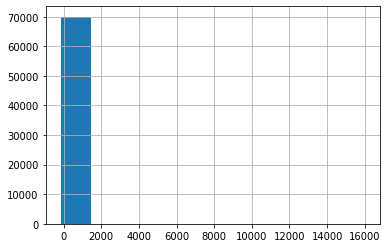

In [17]:
data['ap_hi'].hist()

<AxesSubplot:>

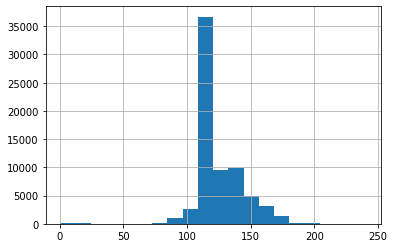

In [18]:
data.loc[(data['ap_hi']<250)&(data['ap_hi']>0),'ap_hi'].hist(bins=20)

In [19]:
data['ap_hi'].quantile([0.025, 0.975])

0.025    100.0
0.975    170.0
Name: ap_hi, dtype: float64

<AxesSubplot:>

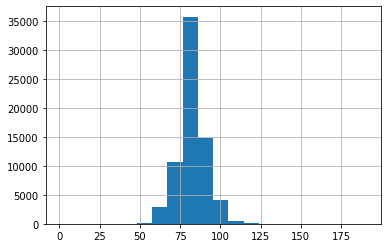

In [20]:
data.loc[(data['ap_lo']<250)&(data['ap_lo']>0),'ap_lo'].hist(bins=20)

In [21]:
data.loc[data['ap_lo']>250, 'cardio'].value_counts()

1    804
0    149
Name: cardio, dtype: int64

In [22]:
def norma_deviation(x):
    a = x.copy()
    q025 = x.quantile(0.025)
    q975 = x.quantile(0.975)
    a.loc[a <= q025] = -1
    a.loc[(a > q025)&(a < q975)] = 0
    a.loc[a >= q975] = 1

    return a          

In [23]:
a = data[['ap_hi', 'ap_lo', 'cardio']].copy()

a['ap_hi'] = norma_deviation(a['ap_hi'])
a['ap_lo'] = norma_deviation(a['ap_lo'])

a.groupby('cardio').mean()

,ap_hi,ap_lo
cardio,,
0,-0.082351,-0.034893
1,0.022413,0.118414


In [24]:
data['cholesterol'].value_counts()

1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64

In [25]:
data['gluc'].value_counts()

1    59479
3     5331
2     5190
Name: gluc, dtype: int64

In [26]:
data['gender'].value_counts()


1    45530
2    24470
Name: gender, dtype: int64

In [27]:
data['smoke'].value_counts()

0    63831
1     6169
Name: smoke, dtype: int64

In [28]:
data['alco'].value_counts()

0    66236
1     3764
Name: alco, dtype: int64

In [29]:
data['active'].value_counts()

1    56261
0    13739
Name: active, dtype: int64

In [30]:
data[['smoke', 'alco', 'active', 'cardio']].groupby('cardio').sum()

,smoke,alco,active
cardio,,,
0,3240,1941,28643
1,2929,1823,27618


In [31]:
a = data[['smoke', 'alco', 'active', 'cardio']].copy()

In [32]:
a['sa'] = a['smoke'] * a['alco']

In [33]:
a['sai'] = a['smoke'] * a['alco'] * abs(a['active']-1)
a['si'] = a['smoke'] * abs(a['active']-1)
a['ai'] = a['alco'] * abs(a['active']-1)

In [34]:
a.groupby('cardio').sum()

,smoke,alco,active,sa,sai,si,ai
cardio,,,,,,,
0,3240,1941,28643,1030,126,449,268
1,2929,1823,27618,824,156,558,311


In [35]:
a['saac'] = a['smoke'] * a['alco'] * a['active']
a['sac'] = a['smoke'] * a['active']
a['aac'] = a['alco'] * a['active']

In [36]:
a.groupby('cardio').sum()

,smoke,alco,active,sa,sai,si,ai,saac,sac,aac
cardio,,,,,,,,,,
0,3240,1941,28643,1030,126,449,268,904,2791,1673
1,2929,1823,27618,824,156,558,311,668,2371,1512


In [37]:
data.groupby('cardio').mean()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI
cardio,,,,,,,,,,,,,
0,49862.869107,18881.623711,1.345707,164.493104,71.594977,120.432598,84.251763,1.216527,1.175380,0.092516,0.055424,0.817881,26.493594
1,50082.102233,20056.813031,1.353441,164.298865,76.827342,137.212042,109.023929,1.517396,1.277595,0.083736,0.052117,0.789559,28.519877


In [38]:
data = pd.read_csv("C:/Users/li_le/geekbrains_study/ML_business/train_case2.csv", sep=';')

In [39]:
x_train, x_test, y_train, y_test = train_test_split(data.drop('cardio', 1), data['cardio'], test_size=0.3, random_state=13)

In [40]:
x_train.to_csv("X_train.csv", index=None)
x_test.to_csv("X_test.csv", index=None)

y_train.to_csv("y_train.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

In [41]:
y_train.value_counts()

1    24528
0    24472
Name: cardio, dtype: int64

In [42]:
y_test.value_counts()

0    10549
1    10451
Name: cardio, dtype: int64

In [43]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column] 
    

In [44]:
cont_features = Pipeline([('selector', FeatureSelector(column=['age', 'height', 'weight', 'ap_hi', 'ap_lo'])),
                          ('standard', StandardScaler())
                         ])

In [45]:
feature_processing = FeatureUnion([('cont_features', cont_features),
                      ('other',FeatureSelector(column=['smoke', 'alco', 'active', 'gender', 'cholesterol', 'gluc']))
                      ])

In [46]:
# def standard_scale(x):
#     res = (x - x.mean(axis=0)) / x.std(axis=0)
#     return res

In [47]:
# def minmax_scale(x):
#     res = (x - x.min(axis=0)) / (x.max(axis=0)-x.min(axis=0))
#     return res

In [48]:
# class DataProcessing(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         X1 = X.copy()
#         X1['gender'] = X1['gender'].map({1: 0, 2: 1})
        
#         X1.loc[(X1['height'] > 230)|(X1['height'] < 100), 'height'] = X1['height'].median()
#         X1.loc[X1['weight'] < 25, 'weight'] = X1['weight'].median()
#         X1.loc[X1['ap_hi'] <= 0, 'ap_hi'] = data['ap_hi'].median()
#         X1.loc[X1['ap_lo'] <= 0, 'ap_lo'] = data['ap_lo'].median()
        
# #         X1['BMI'] = X1['weight'] / (X1['height'] / 100)**2
        
# #         X1['ap_hi_cat'] = norma_deviation(X1['ap_hi'])
# #         X1['ap_lo_cat'] = norma_deviation(X1['ap_lo'])
#         X1[['age', 'height', 'weight', 'ap_hi', 'ap_lo']] = standard_scale(X1[['age', 'height', 'weight', 'ap_hi', 'ap_lo']])
         
# #         X1['smoke+alco+active'] = X1['smoke'] * X1['alco'] * X1['active']
# #         X1['smoke+inective'] = X1['smoke'] * abs(X1['active']-1)
# #         X1['alco+inective'] = X1['alco'] * abs(X1['active']-1)
        
#         return X1.drop('id', 1)

In [49]:
# dp = DataProcessing()

# x_train_tr = dp.fit_transform(x_train)

# x_test_tr = dp.fit_transform(x_test)

In [50]:
# selected_features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
#        'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'ap_hi_cat',
#        'ap_lo_cat', 'BMI', 'smoke+alco+active', 'smoke+inective',
#        'alco+inective']
# selected_features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
#        'gluc', 'smoke', 'alco', 'active']

In [51]:
# model2 = RandomForestClassifier(random_state=7)

In [52]:
# params = params={'max_features':[3, 5, 7],
#         'min_samples_leaf':[2, 3, 4],
#         'max_depth':[7, 10, 15]
#         }
# grid = GridSearchCV(model2, param_grid=params, refit=False)
# search = grid.fit(x_train_tr[selected_features], y_train)
# search.best_params_

In [53]:
# model2 = RandomForestClassifier(max_depth=7, max_features=5, min_samples_leaf=4, random_state=7)
# # model2 = RandomForestClassifier(max_depth=10, max_features=5, min_samples_leaf=3, random_state=7)

# model2.fit(x_train_tr, y_train)

In [54]:
# preds = model2.predict_proba(x_test_tr)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_test, preds)

# fscore = (2 * precision * recall) / (precision + recall)

# ix = np.argmax(fscore)
# print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                         fscore[ix],
#                                                                         precision[ix],
#                                                                         recall[ix]))

In [55]:
# poly = PolynomialFeatures(2)
# big_table_train = poly.fit_transform(x_train_tr)
# big_table_test = poly.fit_transform(x_test_tr)

In [56]:
# model4 = CatBoostClassifier(random_state=13, silent=True)

In [57]:
# params={'iterations':[40, 50],
#         'learning_rate':[0.5, 1],
#         'depth':[2, 3, 4]
#         }

In [58]:
# grid = GridSearchCV(model4,
#                     param_grid=params,
#                     cv=5,
#                     refit=False)

# search = grid.fit(big_table_train, y_train)
# search.best_params_

In [59]:
# model4 = CatBoostClassifier(depth=3, iterations=40, learning_rate=0.5, random_state=13, silent=True)
# model4.fit(big_table_train, y_train)

In [60]:
# preds = model4.predict_proba(big_table_test)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_test, preds)

# fscore = (2 * precision * recall) / (precision + recall)

# ix = np.argmax(fscore)
# print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                         fscore[ix],
#                                                                         precision[ix],
#                                                                         recall[ix]))

In [61]:
# feature_importances = pd.DataFrame(model4.feature_importances_, columns=['coefficient'])
# feature_importances.sort_values(by='coefficient', inplace=True, ascending=False)
# selected_features = feature_importances.head(60)

In [62]:
# selected_features = feature_importances.head(20)

In [63]:
# big_table_test[:, selected_features.index]

In [64]:
pipeline = Pipeline([
    ('feature_processing', feature_processing),
    ('poly', PolynomialFeatures(2)),
    ('classifier', CatBoostClassifier(depth=3, iterations=40, learning_rate=0.5, random_state=13, silent=True)),
])

pipeline.fit(x_train, y_train)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('cont_features',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column=['age',
                                                                                          'height',
                                                                                          'weight',
                                                                                          'ap_hi',
                                                                                          'ap_lo'])),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('other',
                                                 FeatureSelector(column=['smoke',
             

In [65]:
with open("lesson9_model.dill", "wb") as f:
    dill.dump(pipeline, f)

### Сервис обработки запросов

In [66]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [67]:
with open('lesson9_model.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [68]:
preds = pipeline.predict_proba(X_test)[:, 1]

pred_df = pd.DataFrame({'preds': preds})
pred_df.to_csv("test_predictions.csv", index=None)

In [69]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3912638330159812, F-Score=0.741, Precision=0.697, Recall=0.791


In [70]:
app = Flask(__name__)

@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    features={el: 0 for el in ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active']}
    request_json = request.get_json()
    
    for feature in features.keys():
        if request_json[feature]:
            features[feature] = [request_json[feature]]
            

    preds = pipeline.predict_proba(pd.DataFrame(features))
    data["predictions"] = preds[:, 1][0]
    
        # indicate that the request was a success
    data["success"] = True
    print('OK')

        # return the data dictionary as a JSON response
    return jsonify(data)


if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [23/Apr/2023 13:12:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:00] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Apr/2023 13:12:37] "POST //predict HTTP/1.1" 200 -


OK


127.0.0.1 - - [23/Apr/2023 13:12:47] "POST //predict HTTP/1.1" 200 -


OK


127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:5

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:5

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:5

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:58] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:5

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:5

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:5

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:5

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:5

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:59] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:12:5

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:00] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK

127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0


OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:01] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK

127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0


OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK

127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:02] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0


OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK

127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0


OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK

127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0


OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:0

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:03] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:04] "POST //predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2023 13:13:04] "POST //predict HTTP/1.1" 200 -


OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
